# Shift 2.0 Challenge - MS Lesion Segmentation

# First : Create the Baseline Model

## Download the data and visualize it

This data set consists of longitudinal imaging data from 5 subjects. The top-level directory consists of directories named according to subject. Within each subject directory are three directories:

- “orig” – containing the original MR images
- “preprocessed” – containing the images after co-registration, brain extraction, and non-uniformity correction
- “masks” – which contain binary images representing lesion locations.

We have a bit of work before actually being able to use the data.

### 1. Import the necessary library

In [ ]:
# Cell 1: Imports
import requests
import zipfile
import os
import ssl
import nibabel as nib
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Tuple, List, Dict

from dataclasses import dataclass
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

import cv2

from functools import lru_cache

### 2. Download the dataset from the server

This is to avoid having to upload the dataset into colab each time, this is also faster. Once downloaded, we extract the .zip file to have access to the files.

In [ ]:
import requests
import zipfile
import os
import ssl
from tqdm import tqdm

# Step 1: Download the dataset with progress bar
url = "https://smart-stats-tools.org/sites/default/files/lesion_challenge/training_final_v4.zip"
local_zip_file = "training_final_v4.zip"

# Create an unverified SSL context
context = ssl._create_unverified_context()

# Get the response with stream=True to download in chunks
response = requests.get(url, stream=True, verify=False)

# Get the total file size from the headers
total_size = int(response.headers.get('content-length', 0))

# Open the file in write-binary mode and write the content in chunks
with open(local_zip_file, 'wb') as file, tqdm(
    desc=local_zip_file,
    total=total_size,
    unit='iB',
    unit_scale=True,
    unit_divisor=1024,
) as bar:
    for data in response.iter_content(chunk_size=1024):
        size = file.write(data)
        bar.update(size)

# Step 2: Unzip the downloaded file
with zipfile.ZipFile(local_zip_file, 'r') as zip_ref:
    zip_ref.extractall("training_data")

# Step 3: List the contents of the unzipped directory
unzipped_dir = "training_data"
for root, dirs, files in os.walk(unzipped_dir):
    for name in files:
        print(os.path.join(root, name))
    for name in dirs:
        print(os.path.join(root, name))

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'smart-stats-tools.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
training_final_v4.zip: 100%|██████████| 786M/786M [00:40<00:00, 20.2MiB/s]


training_data/training
training_data/training/license.txt.bak
training_data/training/license.txt
training_data/training/2017-NI-Carass-Longitudinal-multiple-sclerosis-lesion-segmentation-Resource-and-challenge.pdf
training_data/training/training02
training_data/training/training05
training_data/training/training03
training_data/training/training01
training_data/training/training04
training_data/training/training02/masks
training_data/training/training02/orig
training_data/training/training02/preprocessed
training_data/training/training02/masks/training02_04_mask1.nii
training_data/training/training02/masks/training02_02_mask2.nii
training_data/training/training02/masks/training02_04_mask2.nii
training_data/training/training02/masks/training02_03_mask1.nii
training_data/training/training02/masks/training02_01_mask2.nii
training_data/training/training02/masks/training02_03_mask2.nii
training_data/training/training02/masks/training02_01_mask1.nii
training_data/training/training02/masks/tr

### Create the dataset for training
Since the data is in .nii format, we will have a bit of work to do before being able to use it. First we start by creating a Dataset that we will use for training and testing the CNN.

In [ ]:
@dataclass
class BrainMRIConfig:
    data_root: str
    image_size: Tuple[int, int] = (256, 256)
    batch_size: int = 16
    modalities: List[str] = ('flair',)
    buffer_size: int = 1000
    seed: int = 42
    split: str = 'train'  # Options: 'train', 'val', 'test'
    train_ratio: float = 0.7
    val_ratio: float = 0.15

In [ ]:
class BrainMRIDataGenerator:
    def __init__(self, config: BrainMRIConfig):
        self.config = config
        self.data_root = Path(config.data_root)

    def _load_volume(self, file_path: str) -> np.ndarray:
        """Load and normalize a NIfTI volume"""
        volume = nib.load(file_path).get_fdata()
        return (volume - volume.min()) / (volume.max() - volume.min())

    def _get_slice_pairs(self) -> List[Dict]:
        """Generate (image, mask) slice pairs"""
        slice_pairs = []

        for patient_folder in sorted(self.data_root.glob("training/training[0-9]*")):
            patient_id = patient_folder.name

            # Get paths
            prep_path = patient_folder / "preprocessed"
            mask_path = patient_folder / "masks"

            # For each modality
            for modality in self.config.modalities:
                prep_files = list(prep_path.glob(f"*{modality}*pp.nii"))
                for prep_file in prep_files:
                    # Find corresponding mask
                    timepoint = prep_file.stem.split('_')[1]
                    mask_file = mask_path / f"{patient_id}_{timepoint}_mask1.nii"

                    if mask_file.exists():
                        slice_pairs.append({
                            'image_path': str(prep_file),
                            'mask_path': str(mask_file)
                        })

        return slice_pairs

### Fill the dataset

Once we have the actual Dataset structure ready, we need to fill it by slicing the .nii files.

In [ ]:
@lru_cache(maxsize=128)
def cached_load_volume(file_path: str) -> np.ndarray:
    """Cached version of volume loading"""
    return nib.load(file_path).get_fdata()

def create_dataset(config: BrainMRIConfig) -> tf.data.Dataset:
    start_time = time.time()
    generator = BrainMRIDataGenerator(config)
    slice_pairs = generator._get_slice_pairs()

    # Pre-compute valid slices
    print("Computing valid slices...")
    valid_slices = []
    for pair in slice_pairs:
        t0 = time.time()
        image_vol = cached_load_volume(pair['image_path'])
        mask_vol = cached_load_volume(pair['mask_path'])

        for idx in range(image_vol.shape[2]):
            image_slice = image_vol[:, :, idx]
            mask_slice = mask_vol[:, :, idx]

            # Remove empty slices as they are not needed for training
            if np.sum(image_slice) >= 100 and np.sum(mask_slice) >= 100:
                valid_slices.append((pair, idx))

    print(f"Found {len(valid_slices)} valid slices in {time.time() - start_time:.2f}s")

    # Split data
    np.random.seed(config.seed)
    np.random.shuffle(valid_slices)

    n_total = len(valid_slices)
    n_train = int(n_total * config.train_ratio)
    n_val = int(n_total * config.val_ratio)

    if config.split == 'train':
        selected_slices = valid_slices[:n_train]
        shuffle = True
    elif config.split == 'val':
        selected_slices = valid_slices[n_train:n_train + n_val]
        shuffle = False
    else:
        selected_slices = valid_slices[n_train + n_val:]
        shuffle = False

    def data_generator():
        for pair, idx in selected_slices:
            image_vol = cached_load_volume(pair['image_path'])
            mask_vol = cached_load_volume(pair['mask_path'])

            image_slice = image_vol[:, :, idx]
            mask_slice = mask_vol[:, :, idx]

            # Convert and reshape
            image_slice = tf.convert_to_tensor(image_slice, dtype=tf.float32)
            mask_slice = tf.convert_to_tensor(mask_slice, dtype=tf.float32)

            if image_slice.shape != config.image_size:
                image_slice = tf.image.resize(image_slice[..., tf.newaxis], config.image_size)
                mask_slice = tf.image.resize(mask_slice[..., tf.newaxis], config.image_size)
            else:
                image_slice = image_slice[..., tf.newaxis]
                mask_slice = mask_slice[..., tf.newaxis]

            # Make the masks binary
            mask_slice = tf.where(mask_slice > 0.5, 1.0, 0.0)

            yield image_slice, mask_slice

    # Create dataset with performance optimizations
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        output_signature=(
            tf.TensorSpec(shape=(*config.image_size, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(*config.image_size, 1), dtype=tf.float32)
        )
    )

    if shuffle:
        dataset = dataset.shuffle(config.buffer_size, seed=config.seed)

    if config.split == 'train':
        dataset = dataset.repeat()

    # Add caching
    dataset = dataset.cache()
    dataset = dataset.batch(config.batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    print(f"Dataset creation took {time.time() - start_time:.2f}s")
    return dataset

### Test the dataset

Now we need to test the dataset to make sure it works and that the images / masks combination are good.

In [ ]:
def display_samples(dataset, num_samples=5):
    """
    Displays samples from the dataset.

    Args:
        dataset: The tf.data.Dataset to display samples from.
        num_samples: The number of samples to display.
    """
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    for idx, (images, masks) in enumerate(dataset.take(num_samples)):
        # The error was due to the images tensor having a shape of (batch_size, height, width, channels)
        # while imshow expects a 2D or 3D tensor with the last dimension being the channels.
        # By selecting the first image in the batch and the first channel, we get the correct shape.
        axes[idx, 0].imshow(images[0, :, :, 0], cmap='gray')  # Changed ... to :, :
        axes[idx, 0].set_title(f'Image {idx}')

        axes[idx, 1].imshow(masks[0, :, :, 0], cmap='gray')  # Changed ... to :, :
        axes[idx, 1].set_title(f'Mask {idx}')

        axes[idx, 2].imshow(images[0, :, :, 0], cmap='gray')  # Changed ... to :, :
        axes[idx, 2].imshow(masks[0, :, :, 0], alpha=0.3, cmap='Reds')  # Changed ... to :, :
        axes[idx, 2].set_title(f'Overlay {idx}')

    plt.tight_layout()
    plt.show()

Computing valid slices...
Found 610 valid slices in 1.10s
Dataset creation took 1.15s
Computing valid slices...
Found 610 valid slices in 0.24s
Dataset creation took 0.26s
Computing valid slices...
Found 610 valid slices in 0.23s
Dataset creation took 0.26s

Displaying training samples:


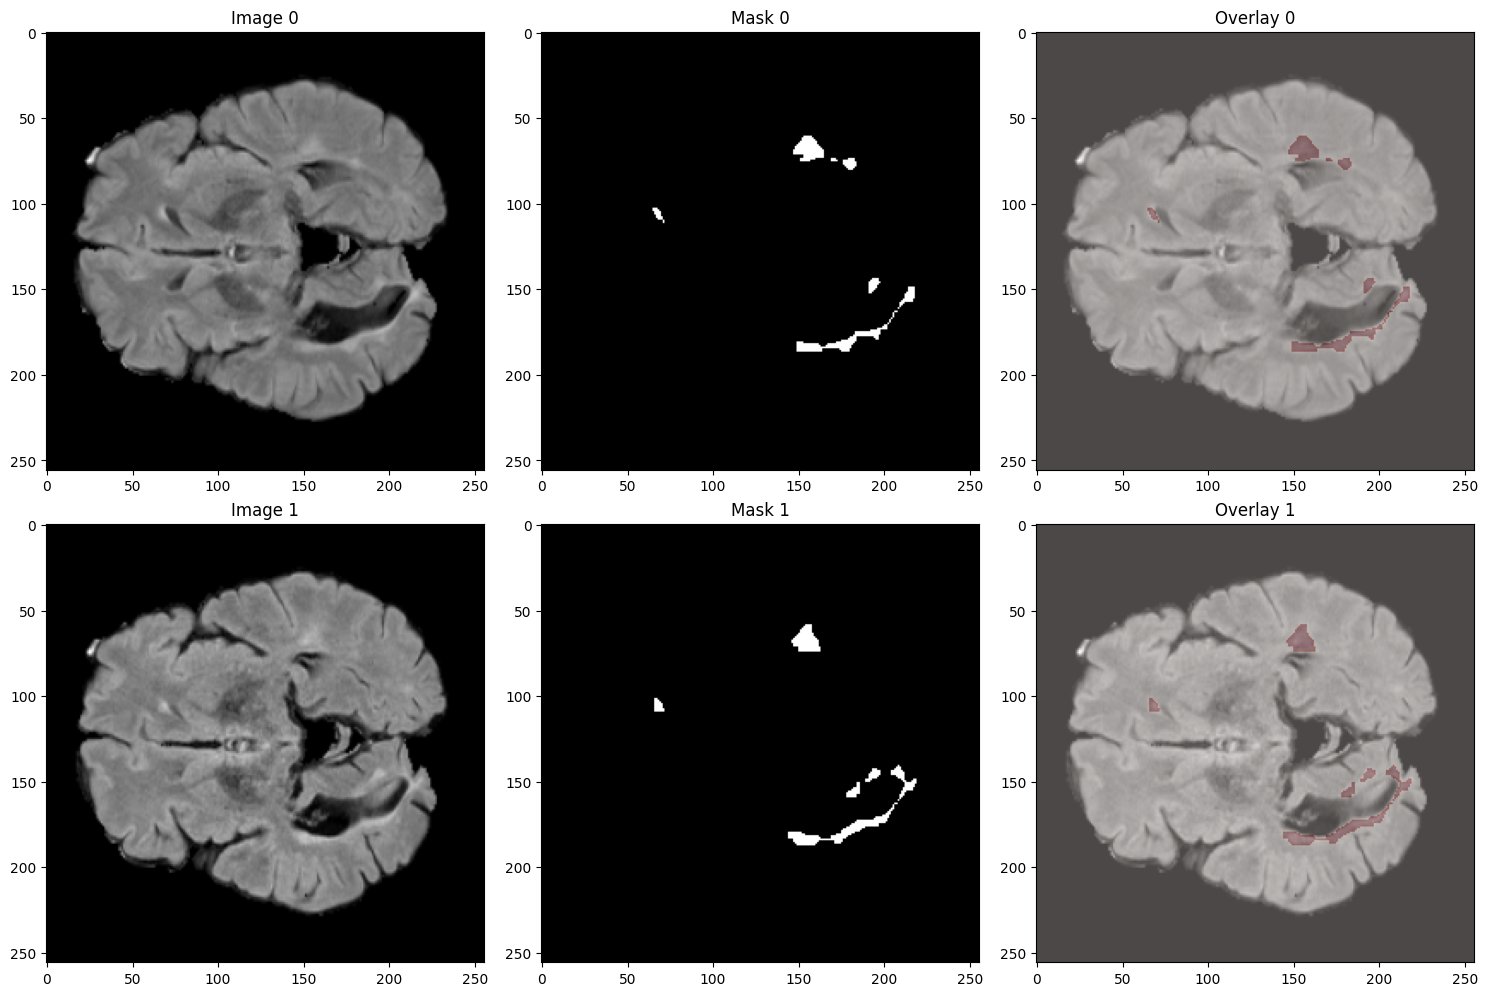


Displaying validation samples:


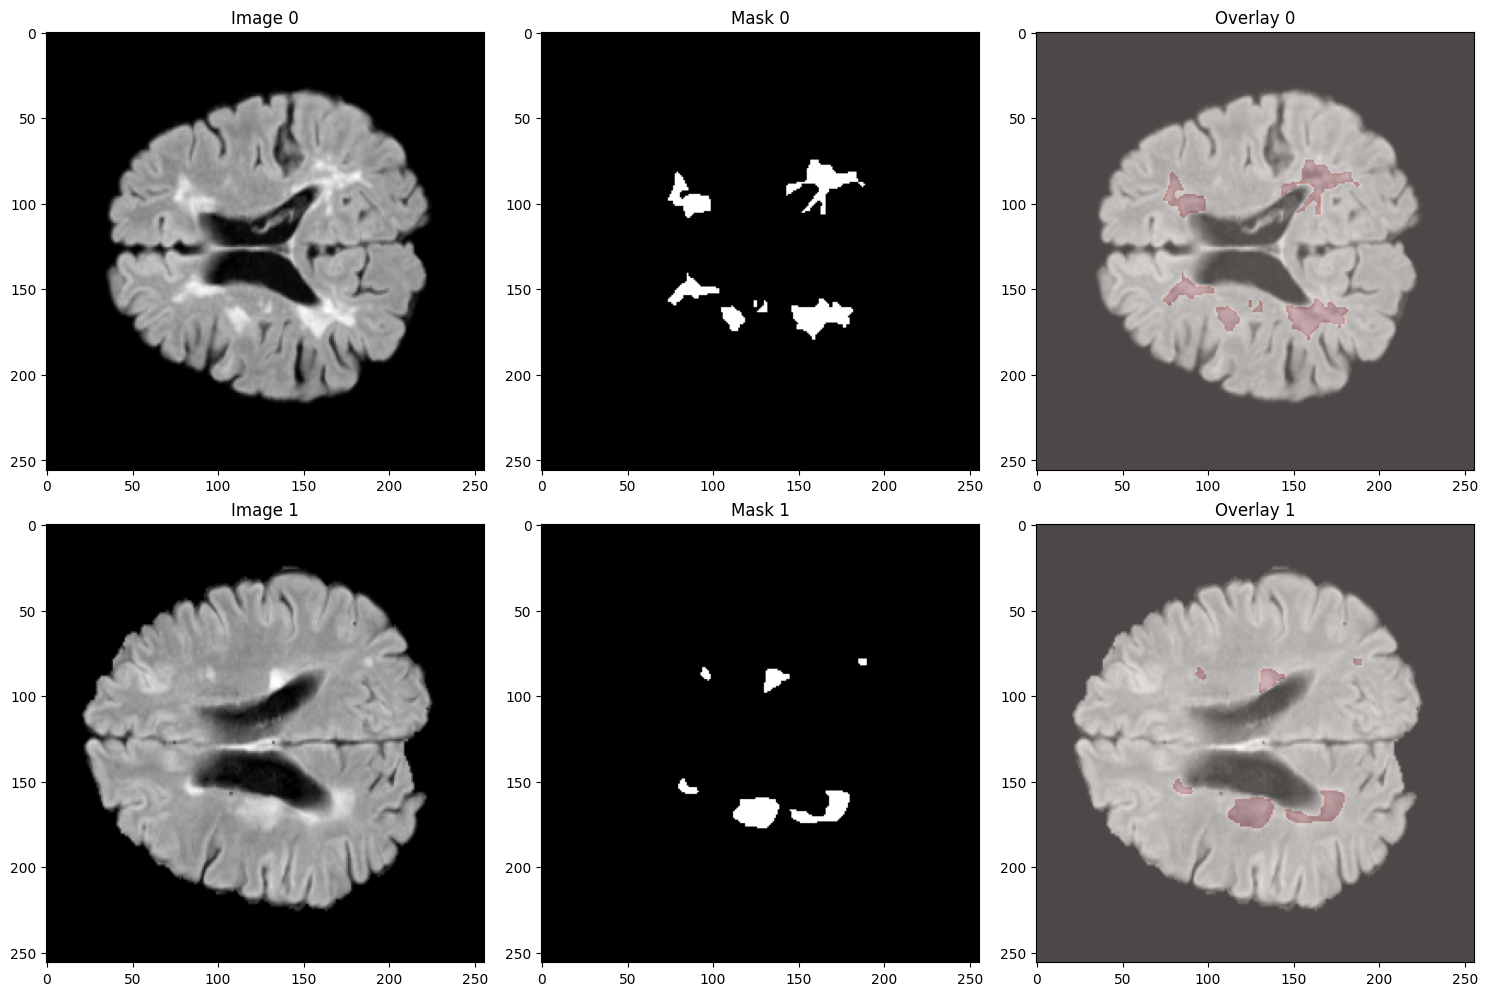


Displaying test samples:


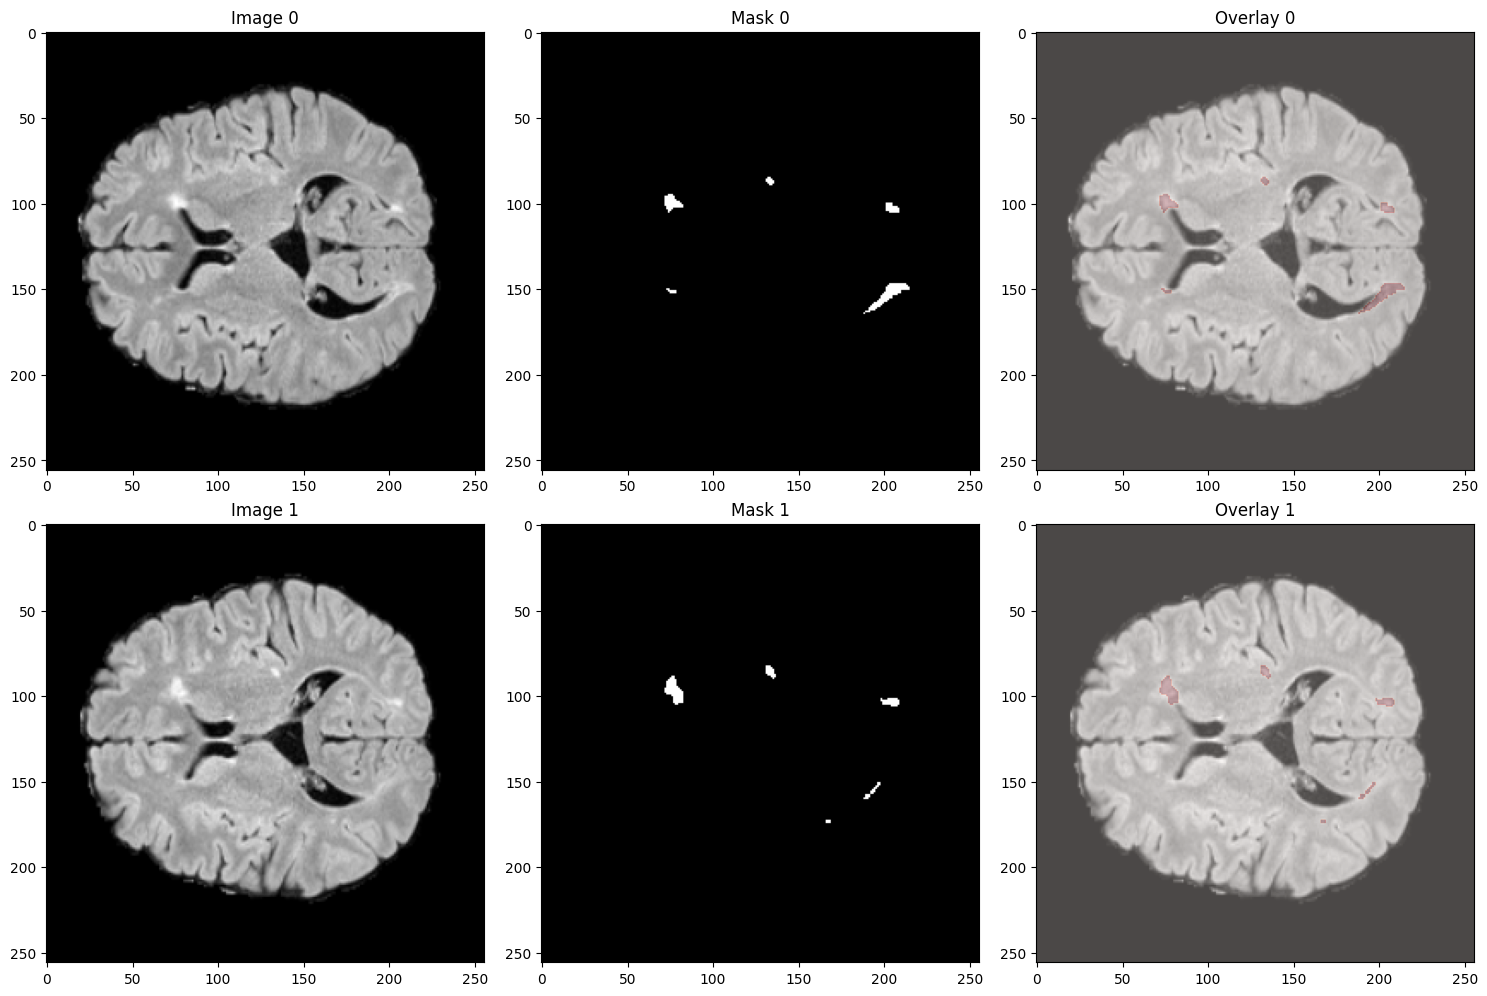


Dataset sizes:


In [ ]:
# Test Cell
# Create configs for each split
train_config = BrainMRIConfig(
    data_root="training_data",
    image_size=(256, 256),
    batch_size=8,
    split='train'
)

val_config = BrainMRIConfig(**{**train_config.__dict__, 'split': 'val'})
test_config = BrainMRIConfig(**{**train_config.__dict__, 'split': 'test'})

# Create datasets
train_ds = create_dataset(train_config)
val_ds = create_dataset(val_config)
test_ds = create_dataset(test_config)

# Display samples from each split
print("\nDisplaying training samples:")
display_samples(train_ds, num_samples=2)
print("\nDisplaying validation samples:")
display_samples(val_ds, num_samples=2)
print("\nDisplaying test samples:")
display_samples(test_ds, num_samples=2)

# Print dataset sizes
print("\nDataset sizes:")
print(f"Training batches: {len(list(train_ds))}")
print(f"Validation batches: {len(list(val_ds))}")
print(f"Test batches: {len(list(test_ds))}")

## Create the Model

Now that we have working data, we can move on to the model. For the baseline we are going to use a classic U-Net architecture from PW1.

In [ ]:
def create_unet(input_shape=(256, 256, 1)):
    # Input layer
    inputs = Input(input_shape)

    # Initialize a kernel
    kernel_init = tf.keras.initializers.HeNormal()


    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_init)(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bridge
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

### Create the Loss function and some metrics

Before starting to train the model, we need some custom Loss function because the data is imbalanced and standard cross entropy won't work. We are going to create a "Weighted BCE Dice Loss" function.

In [ ]:
# Define Dice coefficient metric
def dice_coefficient(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1.)

# Loss function
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [ ]:
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    """
    Focal loss for addressing class imbalance.
    gamma: Focusing parameter for hard examples
    alpha: Weight for the positive class
    """
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1.0 - tf.keras.backend.epsilon())
    loss = - y_true * alpha * tf.pow(1 - y_pred, gamma) * tf.math.log(y_pred) \
           - (1 - y_true) * (1 - alpha) * tf.pow(y_pred, gamma) * tf.math.log(1 - y_pred)
    return tf.reduce_mean(loss)

In [ ]:
def weighted_bce_dice_loss(y_true, y_pred, alpha=0.5, beta=0.5, pos_weight=25.0):
    """Increased positive class weight significantly"""
    def weighted_bce(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        loss = pos_weight * y_true * tf.math.log(y_pred) + \
               (1 - y_true) * tf.math.log(1 - y_pred)
        return -tf.reduce_mean(loss)

    dice = dice_loss(y_true, y_pred)
    bce = weighted_bce(y_true, y_pred)
    return alpha * bce + beta * dice

def focal_tversky_loss(y_true, y_pred, alpha=0.7, gamma=0.75):
    """
    Focal Tversky Loss for handling class imbalance
    alpha: controls FP/FN trade-off
    gamma: focal parameter
    """
    eps = 1e-7

    # Compute True Positives, False Positives, False Negatives
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1-y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1-y_pred))

    tversky = (tp + eps) / (tp + alpha*fp + (1-alpha)*fn + eps)
    focal_tversky = tf.pow((1-tversky), gamma)

    return focal_tversky

### Start the training process

Now that we have tested the Loss function, we can move on to starting the training process.



In [ ]:
# Update Configuration
@dataclass
class TrainConfig:
    epochs: int = 100
    learning_rate: float = 1e-3  # Increased learning rate
    batch_size: int = 16  # Increased batch size
    image_size: Tuple[int, int] = (256, 256)
    data_root: str = "training_data"

# Create configs
train_config = TrainConfig()

#### Create the datasets

In [ ]:
# Dataset Creation
# Create base config for data
data_config = BrainMRIConfig(
    data_root=train_config.data_root,
    image_size=train_config.image_size,
    batch_size=train_config.batch_size,
    split='train'  # default split
)

# Create train/val/test configs
train_data_config = BrainMRIConfig(
    data_root=data_config.data_root,
    image_size=data_config.image_size,
    batch_size=data_config.batch_size,
    split='train'
)

val_data_config = BrainMRIConfig(
    data_root=data_config.data_root,
    image_size=data_config.image_size,
    batch_size=data_config.batch_size,
    split='val'
)

test_data_config = BrainMRIConfig(
    data_root=data_config.data_root,
    image_size=data_config.image_size,
    batch_size=data_config.batch_size,
    split='test'
)

# Create datasets
train_ds = create_dataset(train_data_config)
val_ds = create_dataset(val_data_config)
test_ds = create_dataset(test_data_config)

print(f"Created datasets with batch size: {train_data_config.batch_size}")
print(f"Train split: {train_data_config.split}")
print(f"Val split: {val_data_config.split}")
print(f"Test split: {test_data_config.split}")

In [ ]:
# Function to inspect mask values
def check_mask_values(dataset, num_batches=3):
    for i, (images, masks) in enumerate(dataset.take(num_batches)):
        unique_values = tf.unique(tf.reshape(masks, [-1]))[0].numpy()

# Check mask values in the training dataset
check_mask_values(train_ds)


#### Create the model and compile it

In [ ]:
from keras.losses import BinaryFocalCrossentropy

# Model Compilation
model = create_unet(input_shape=(*train_config.image_size, 1))

# Update optimizer
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=train_config.learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07
    ),
    loss=BinaryFocalCrossentropy(apply_class_balancing=True),
    metrics=[dice_coefficient, 'binary_accuracy',
             tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

model.summary()

#### Create the callbacks for training

In [ ]:
class WarmUpCosineDecay(tf.keras.callbacks.LearningRateScheduler):
    def __init__(self, warmup_epochs=5, total_epochs=100, initial_lr=1e-3):
        super().__init__(self.schedule)
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.initial_lr = initial_lr

    def schedule(self, epoch):
        if epoch < self.warmup_epochs:
            return self.initial_lr * (epoch + 1) / self.warmup_epochs
        else:
            return self.initial_lr * 0.5 * (1 + np.cos(np.pi * (epoch - self.warmup_epochs) /
                   (self.total_epochs - self.warmup_epochs)))


In [ ]:
# Setup Callbacks
# Create checkpoint path
checkpoint_path = "checkpoints/model_{epoch:02d}_{val_loss:.2f}.weights.h5" # Changed the file extension

callbacks = [
    ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        save_weights_only=True
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=5,
        min_lr=1e-6
    ),
    TensorBoard(
        log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
        update_freq='epoch'
    ),
    WarmUpCosineDecay(
        warmup_epochs=5,
        total_epochs=train_config.epochs,
        initial_lr=train_config.learning_rate
    )
]

#### Train the model

In [ ]:
# Training Loop with updated config access
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=train_config.epochs,  # Using dataclass attribute
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
     27/Unknown 120s 2s/step - binary_accuracy: 0.9514 - dice_coefficient: 0.0024 - loss: 35.2716 - precision: 0.0127 - recall: 0.0463  

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


27/27 ━━━━━━━━━━━━━━━━━━━━ 153s 4s/step - binary_accuracy: 0.9523 - dice_coefficient: 0.0024 - loss: 35.6622 - precision: 0.0128 - recall: 0.0458 - val_binary_accuracy: 0.9917 - val_dice_coefficient: 1.3162e-05 - val_loss: 44.1630 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 2.0000e-04
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 650ms/step - binary_accuracy: 0.9858 - dice_coefficient: 0.0015 - loss: 27.5978 - precision: 0.0152 - recall: 0.0133 - val_binary_accuracy: 0.9917 - val_dice_coefficient: 9.5895e-06 - val_loss: 32.3563 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 4.0000e-04
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 653ms/step - binary_accuracy: 0.9885 - dice_coefficient: 0.0021 - loss: 22.1282 - precision: 0.0264 - recall: 0.0145 - val_binary_accuracy: 0.9917 - val_dice_coefficient: 1.2554e-05 - val_loss: 15.5370 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 6.0000e-04
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━

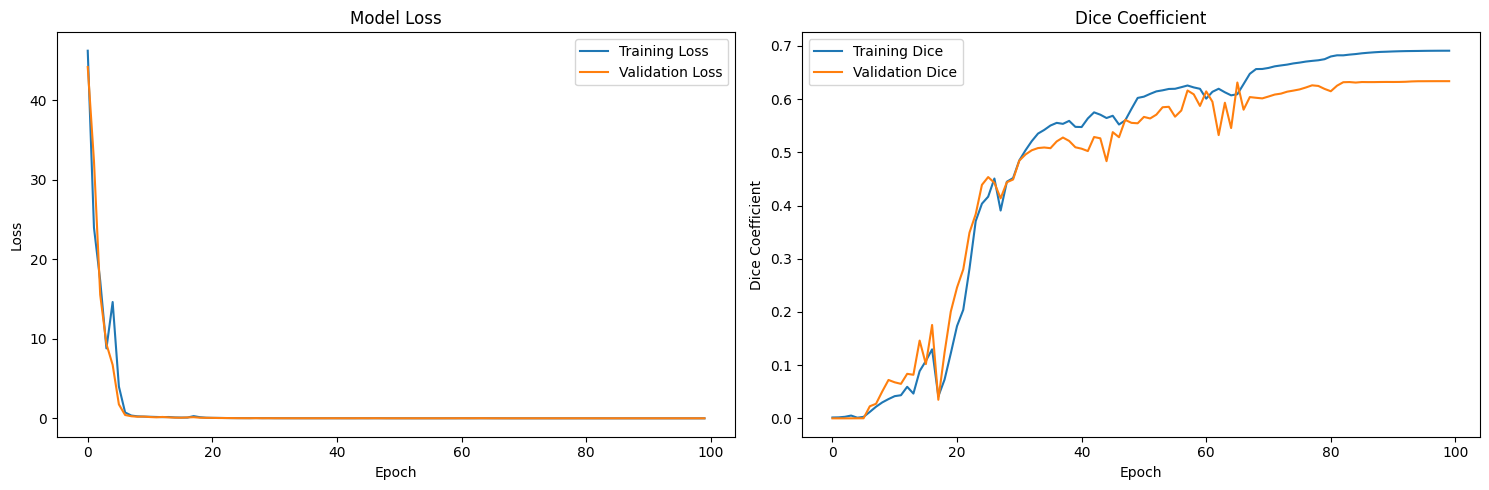

In [ ]:
# Plot Training History

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Dice coefficient plot
    ax2.plot(history.history['dice_coefficient'], label='Training Dice')
    ax2.plot(history.history['val_dice_coefficient'], label='Validation Dice')
    ax2.set_title('Dice Coefficient')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Dice Coefficient')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
model.save('model_97epochs_focal_loss.keras')

### Test the model

Now that we have our baseline model trained, we can test it on the test dataset.

In [ ]:
# Evaluate the model on the test dataset
loss, dice, accuracy, recall, precision = model.evaluate(test_ds)

print(f"Test Loss: {loss}")
print(f"Test Dice Coefficient: {dice}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Recall: {recall}")
print(f"Test Precision: {precision}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - binary_accuracy: 0.9964 - dice_coefficient: 0.6282 - loss: 0.0128 - precision: 0.8995 - recall: 0.6520
Test Loss: 0.013298693113029003
Test Dice Coefficient: 0.6428032517433167
Test Accuracy: 0.9964191317558289
Test Recall: 0.6730213761329651
Test Precision: 0.9025964140892029


Result of the evaluation of the model :  
- Test Loss: 0.0133
- Test Dice Coefficient: 0.643
- Test Accuracy: 0.996
- Test Recall: 0.673
- Test Precision: 0.902

In [ ]:
def visualize_predictions(model, dataset, num_samples=5):
    """Visualizes predictions side-by-side with images and masks."""
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    for idx, (images, masks) in enumerate(dataset.take(num_samples)):
        predictions = model.predict(images)

        # Select the first image in the batch
        image = images[0, :, :, 0].numpy()
        mask = masks[0, :, :, 0].numpy()
        # make the prediction binary
        predictions = (predictions > 0.5).astype(np.uint8)
        prediction = predictions[0, :, :, 0]

        axes[idx, 0].imshow(image, cmap='gray')
        axes[idx, 0].set_title(f'Image {idx}')

        axes[idx, 1].imshow(mask, cmap='gray')
        axes[idx, 1].set_title(f'Real Mask {idx}')

        axes[idx, 2].imshow(prediction, cmap='gray')
        axes[idx, 2].set_title(f'Predicted Mask {idx}')

    plt.tight_layout()
    plt.show()

In [ ]:
visualize_predictions(model, test_ds, num_samples=2)

# Second : Uprade model performance

## Data Augmentation

The first step for upgrading our model is going to be trying to add data augmentation to tackle the issue of low amount of data. We will add the classic data augmentation techniques, as well as using some kind of repeat to make epochs last longer. This way the model will see more, varied images when training.

### Create a new Dataset Class

In [ ]:
def create_dataset_augmented(config: BrainMRIConfig) -> tf.data.Dataset:
    start_time = time.time()
    generator = BrainMRIDataGenerator(config)
    slice_pairs = generator._get_slice_pairs()

    # Pre-compute valid slices
    print("Computing valid slices...")
    valid_slices = []
    for pair in slice_pairs:
        image_vol = cached_load_volume(pair['image_path'])
        mask_vol = cached_load_volume(pair['mask_path'])

        for idx in range(image_vol.shape[2]):
            image_slice = image_vol[:, :, idx]
            mask_slice = mask_vol[:, :, idx]

            # Remove empty slices as they are not needed for training
            if np.sum(image_slice) >= 100 and np.sum(mask_slice) >= 100:
                valid_slices.append((pair, idx))

    print(f"Found {len(valid_slices)} valid slices in {time.time() - start_time:.2f}s")

    # Split data
    np.random.seed(config.seed)
    np.random.shuffle(valid_slices)

    n_total = len(valid_slices)
    n_train = int(n_total * config.train_ratio)
    n_val = int(n_total * config.val_ratio)

    if config.split == 'train':
        selected_slices = valid_slices[:n_train]
        shuffle = True
    elif config.split == 'val':
        selected_slices = valid_slices[n_train:n_train + n_val]
        shuffle = False
    else:
        selected_slices = valid_slices[n_train + n_val:]
        shuffle = False

    def data_generator():
        for pair, idx in selected_slices:
            image_vol = cached_load_volume(pair['image_path'])
            mask_vol = cached_load_volume(pair['mask_path'])

            image_slice = image_vol[:, :, idx]
            mask_slice = mask_vol[:, :, idx]

            # Convert and reshape
            image_slice = tf.convert_to_tensor(image_slice, dtype=tf.float32)
            mask_slice = tf.convert_to_tensor(mask_slice, dtype=tf.float32)

            image_slice = tf.image.resize(image_slice[..., tf.newaxis], config.image_size)
            mask_slice = tf.image.resize(mask_slice[..., tf.newaxis], config.image_size)

            # Make the masks binary
            mask_slice = tf.where(mask_slice > 0.5, 1.0, 0.0)

            yield image_slice, mask_slice

    def augment(image, mask):
        # Random flip
        flip = tf.random.uniform(shape=[], minval=0, maxval=1, dtype=tf.float32)
        image = tf.cond(flip > 0.5, lambda: tf.image.flip_left_right(image), lambda: image)
        mask = tf.cond(flip > 0.5, lambda: tf.image.flip_left_right(mask), lambda: mask)

        # Random rotation
        k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k=k)
        mask = tf.image.rot90(mask, k=k)

        # Random zoom
        scales = list(np.arange(1, 1.5, 0.1))
        scale = tf.random.shuffle(scales)[0]
        new_height = tf.cast(scale * tf.cast(tf.shape(image)[0], tf.float32), tf.int32)
        new_width = tf.cast(scale * tf.cast(tf.shape(image)[1], tf.float32), tf.int32)
        image = tf.image.resize(image, [new_height, new_width])
        mask = tf.image.resize(mask, [new_height, new_width])

        # Random crop back to original size
        combined = tf.concat([image, mask], axis=-1)
        combined = tf.image.random_crop(combined, size=[*config.image_size, 2])
        image = combined[..., 0, tf.newaxis]
        mask = combined[..., 1, tf.newaxis]

        # Make mask binary again
        mask = tf.where(mask > 0.5, 1.0, 0.0)

        return image, mask

    # Create dataset with performance optimizations
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        output_signature=(
            tf.TensorSpec(shape=(*config.image_size, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(*config.image_size, 1), dtype=tf.float32)
        )
    )

    if shuffle:
        dataset = dataset.shuffle(config.buffer_size, seed=config.seed)

    if config.split == 'train':
        # Apply data augmentation
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        # Repeat the dataset
        dataset = dataset.repeat()
    else :
        # cache the data if we are not applying data augment
        dataset = dataset.cache()

    dataset = dataset.batch(config.batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    print(f"Dataset creation took {time.time() - start_time:.2f}s")
    return dataset


### Create the new "augmented" dataset

In [ ]:
# Dataset Creation
# Create base config for data
data_config = BrainMRIConfig(
    data_root=train_config.data_root,
    image_size=train_config.image_size,
    batch_size=train_config.batch_size,
    split='train'  # default split
)

# Create train/val/test configs
train_data_config = BrainMRIConfig(
    data_root=data_config.data_root,
    image_size=data_config.image_size,
    batch_size=data_config.batch_size,
    split='train'
)

val_data_config = BrainMRIConfig(
    data_root=data_config.data_root,
    image_size=data_config.image_size,
    batch_size=data_config.batch_size,
    split='val'
)

test_data_config = BrainMRIConfig(
    data_root=data_config.data_root,
    image_size=data_config.image_size,
    batch_size=data_config.batch_size,
    split='test'
)

# Create datasets
train_ds = create_dataset_augmented(train_data_config)
val_ds = create_dataset_augmented(val_data_config)
test_ds = create_dataset_augmented(test_data_config)

print(f"Created datasets with batch size: {train_data_config.batch_size}")
print(f"Train split: {train_data_config.split}")
print(f"Val split: {val_data_config.split}")
print(f"Test split: {test_data_config.split}")

### Test the new dataset

In [ ]:
# Display samples from each split
print("\nDisplaying training samples:")
display_samples(train_ds, num_samples=5)

In [ ]:
def check_mask_values(dataset, num_batches=3):
    for i, (images, masks) in enumerate(dataset.take(num_batches)):
        unique_values = tf.unique(tf.reshape(masks, [-1]))[0].numpy()
        print(f"Unique values in mask batch {i}: {unique_values}")
        # Ensure values are either 0 or 1
        if not np.all(np.isin(unique_values, [0, 1])):
          print(f"Warning: Mask batch {i} contains values other than 0 and 1")

In [ ]:
# Check mask values in the training dataset
check_mask_values(train_ds)

### Create and train a new model on the new dataset

In [ ]:
# Model Compilation
model_augmented = create_unet(input_shape=(*train_config.image_size, 1))

# Update optimizer
model_augmented.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=train_config.learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07
    ),
    loss=BinaryFocalCrossentropy(apply_class_balancing=True),
    metrics=[dice_coefficient, 'binary_accuracy',
             tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [ ]:
# Setup Callbacks
# Create checkpoint path
checkpoint_path = "checkpoints/model_augmented_{epoch:02d}_{val_loss:.2f}.weights.h5" # Changed the file extension

callbacks = [
    ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        save_weights_only=True
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=5,
        min_lr=1e-6
    ),
    TensorBoard(
        log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
        update_freq='epoch'
    ),
    WarmUpCosineDecay(
        warmup_epochs=5,
        total_epochs=train_config.epochs,
        initial_lr=train_config.learning_rate
    )
]

### Train the new model

For the training, we will also increase the epochs lenght, from 27 steps per epochs to 50. Since we have randomly augmented data, the data will not be redundant when training, hopefully leading to better performance.

In [ ]:
# Training Loop with updated config access and steps_per_epoch
history = model_augmented.fit(
    train_ds,
    validation_data=val_ds,
    epochs=train_config.epochs,
    steps_per_epoch=50,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - binary_accuracy: 0.8580 - dice_coefficient: 0.0094 - loss: 936.2251 - precision_2: 0.0214 - recall_2: 0.2136

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 687ms/step - binary_accuracy: 0.8599 - dice_coefficient: 0.0093 - loss: 922.8639 - precision_2: 0.0214 - recall_2: 0.2108 - val_binary_accuracy: 0.9880 - val_dice_coefficient: 4.2468e-04 - val_loss: 10.9096 - val_precision_2: 0.0051 - val_recall_2: 0.0023 - learning_rate: 2.0000e-04
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 672ms/step - binary_accuracy: 0.9800 - dice_coefficient: 0.0032 - loss: 17.5555 - precision_2: 0.0195 - recall_2: 0.0108 - val_binary_accuracy: 0.9613 - val_dice_coefficient: 0.0187 - val_loss: 4.1495 - val_precision_2: 0.0334 - val_recall_2: 0.1315 - learning_rate: 4.0000e-04
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 672ms/step - binary_accuracy: 0.9783 - dice_coefficient: 0.0108 - loss: 6.9910 - precision_2: 0.0479 - recall_2: 0.0407 - val_binary_accuracy: 0.9917 - val_dice_coefficient: 2.5294e-05 - val_loss: 9.5902 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 6.0000e-04
Epoch 4/100
50/50 ━━━━━━━━━━━━━━

In [ ]:
# Evaluate the model on the test dataset
loss, dice, accuracy, recall, precision = model_augmented.evaluate(test_ds)

print(f"Test Loss: {loss}")
print(f"Test Dice Coefficient: {dice}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Recall: {recall}")
print(f"Test Precision: {precision}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 379ms/step - binary_accuracy: 0.9945 - dice_coefficient: 0.5096 - loss: 0.0060 - precision_2: 0.8301 - recall_2: 0.4543
Test Loss: 0.006205302197486162
Test Dice Coefficient: 0.5199084877967834
Test Accuracy: 0.9943927526473999
Test Recall: 0.4670911431312561
Test Precision: 0.8341927528381348


Results of the test :
- Test Loss: **0.00620**
- Test Dice Coefficient: *0.519*
- Test Accuracy: *0.994*
- Test Recall: *0.467*
- Test Precision: *0.834*

Before data augmentation :
- Test Loss: *0.0133*
- Test Dice Coefficient: **0.643**
- Test Accuracy: **0.996**
- Test Recall: **0.673**
- Test Precision: **0.902**

So the loss improved, but the actual values we care about (Dice Coefficient, Recall and Precision) didn't. This doesn't mean that data augmentation is a bad thing. Just that the Loss function we are using (Categorial Focal Loss) is maybe not the best one for this particular segmentation task.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


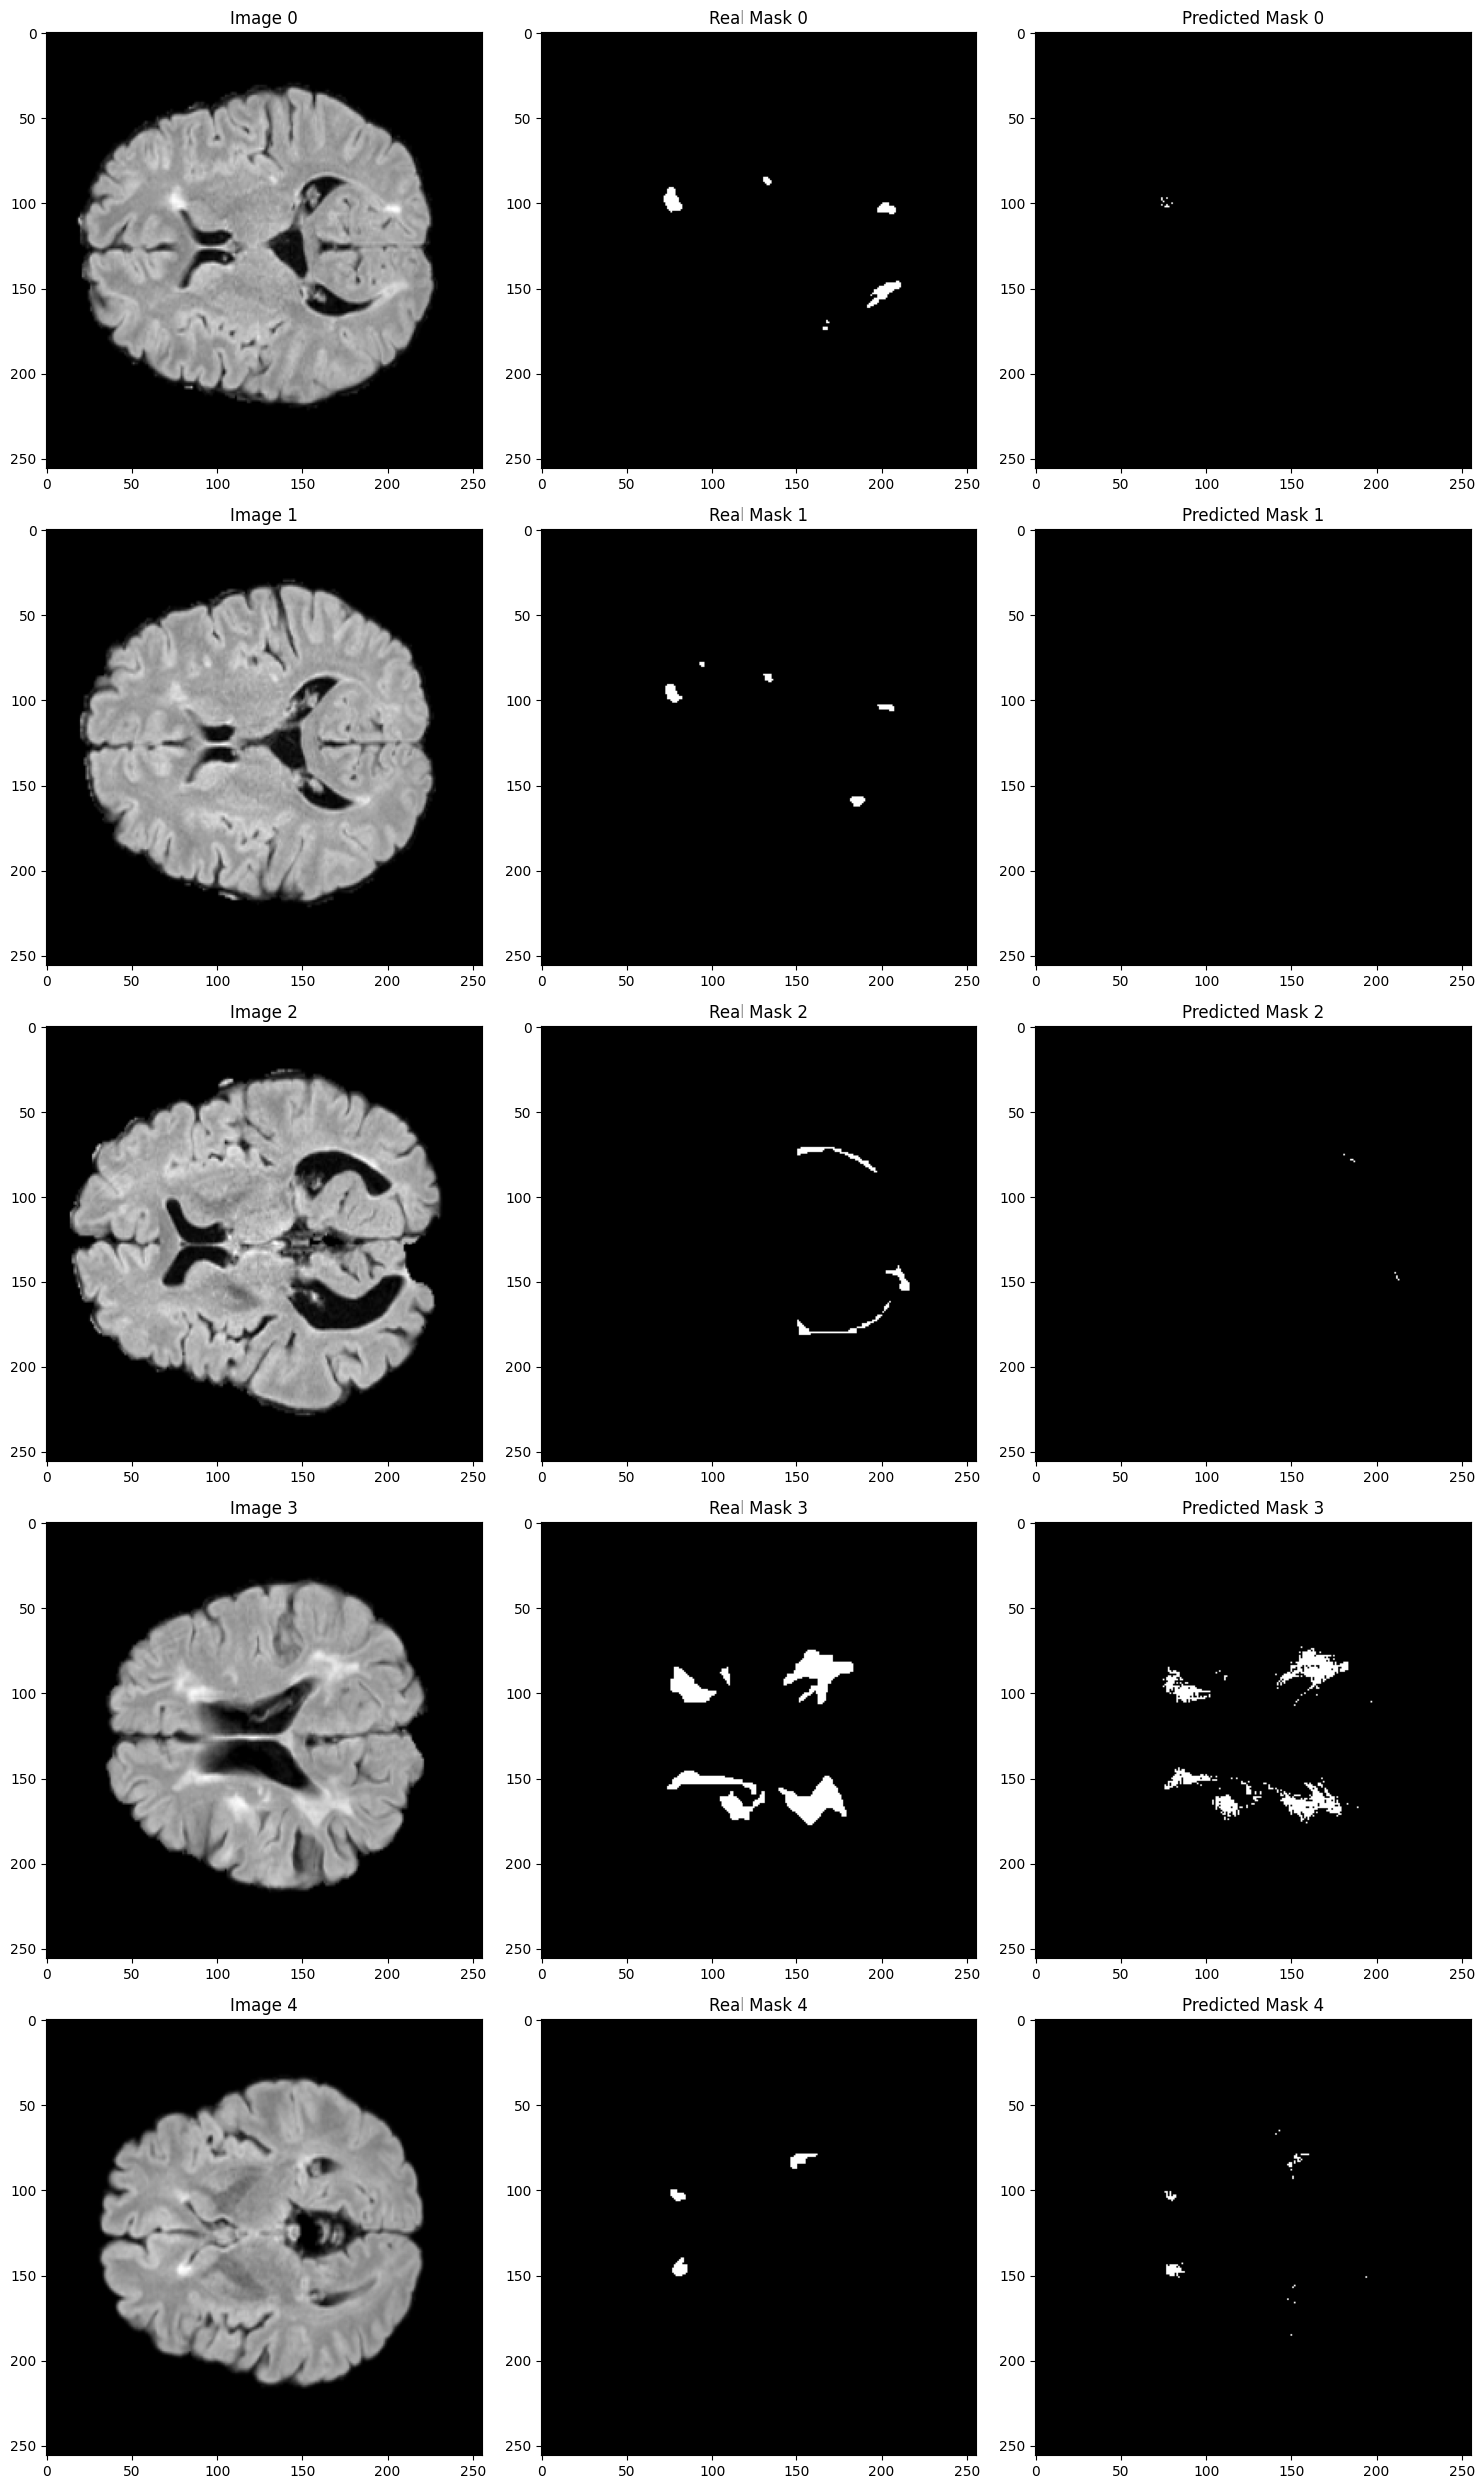

In [ ]:
visualize_predictions(model_augmented, test_ds, num_samples=5)

## Pre-processing of the images

We are now going to try to add pre-processing to the image before feeding them to the model. Since on the FLAIR MRI scans, the white lesion are quite well visible, even to the naked eye, adding some sort of histogram equalization before feeding the image to the model could improve performance, making them even easier to find for the model.

### Create the new dataset function

In [ ]:
def create_dataset_preprocessed(config: BrainMRIConfig) -> tf.data.Dataset:
    start_time = time.time()
    generator = BrainMRIDataGenerator(config)
    slice_pairs = generator._get_slice_pairs()

    # Pre-compute valid slices
    print("Computing valid slices...")
    valid_slices = []
    for pair in slice_pairs:
        t0 = time.time()
        image_vol = cached_load_volume(pair['image_path'])
        mask_vol = cached_load_volume(pair['mask_path'])

        for idx in range(image_vol.shape[2]):
            image_slice = image_vol[:, :, idx]
            mask_slice = mask_vol[:, :, idx]

            # Remove empty slices as they are not needed for training
            if np.sum(image_slice) >= 100 and np.sum(mask_slice) >= 100:
                valid_slices.append((pair, idx))

    print(f"Found {len(valid_slices)} valid slices in {time.time() - start_time:.2f}s")

    # Split data
    np.random.seed(config.seed)
    np.random.shuffle(valid_slices)

    n_total = len(valid_slices)
    n_train = int(n_total * config.train_ratio)
    n_val = int(n_total * config.val_ratio)

    if config.split == 'train':
        selected_slices = valid_slices[:n_train]
        shuffle = True
    elif config.split == 'val':
        selected_slices = valid_slices[n_train:n_train + n_val]
        shuffle = False
    else:
        selected_slices = valid_slices[n_train + n_val:]
        shuffle = False

    def preprocess_image(image):
        # Add a channel dimension
        image = image[..., tf.newaxis]

        # Apply contrast enhancement using TensorFlow operations
        image = tf.image.adjust_contrast(image, 2.0)

        # Remove the channel dimension
        image = tf.squeeze(image, axis=-1)

        # Normalize the image
        image = tf.cast(image, tf.float32) / 255.0

        return image

    def data_generator():
        for pair, idx in selected_slices:
            image_vol = cached_load_volume(pair['image_path'])
            mask_vol = cached_load_volume(pair['mask_path'])

            image_slice = image_vol[:, :, idx]
            mask_slice = mask_vol[:, :, idx]

            # Preprocess the image
            image_slice = preprocess_image(image_slice)

            # Convert and reshape
            image_slice = tf.convert_to_tensor(image_slice, dtype=tf.float32)
            mask_slice = tf.convert_to_tensor(mask_slice, dtype=tf.float32)

            if image_slice.shape != config.image_size:
                image_slice = tf.image.resize(image_slice[..., tf.newaxis], config.image_size)
                mask_slice = tf.image.resize(mask_slice[..., tf.newaxis], config.image_size)
            else:
                image_slice = image_slice[..., tf.newaxis]
                mask_slice = mask_slice[..., tf.newaxis]

            # Make the masks binary
            mask_slice = tf.where(mask_slice > 0.5, 1.0, 0.0)

            yield image_slice, mask_slice

    # Create dataset with performance optimizations
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        output_signature=(
            tf.TensorSpec(shape=(*config.image_size, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(*config.image_size, 1), dtype=tf.float32)
        )
    )

    if shuffle:
        dataset = dataset.shuffle(config.buffer_size, seed=config.seed)

    if config.split == 'train':
        dataset = dataset.repeat()
    else :
      # cache
      dataset = dataset.cache()

    # Add caching
    dataset = dataset.batch(config.batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    print(f"Dataset creation took {time.time() - start_time:.2f}s")
    return dataset

### Create the new datasets

In [ ]:
# Dataset Creation
# Create base config for data
data_config = BrainMRIConfig(
    data_root=train_config.data_root,
    image_size=train_config.image_size,
    batch_size=train_config.batch_size,
    split='train'  # default split
)

# Create train/val/test configs
train_data_config = BrainMRIConfig(
    data_root=data_config.data_root,
    image_size=data_config.image_size,
    batch_size=data_config.batch_size,
    split='train'
)

val_data_config = BrainMRIConfig(
    data_root=data_config.data_root,
    image_size=data_config.image_size,
    batch_size=data_config.batch_size,
    split='val'
)

test_data_config = BrainMRIConfig(
    data_root=data_config.data_root,
    image_size=data_config.image_size,
    batch_size=data_config.batch_size,
    split='test'
)

# Create datasets
train_ds = create_dataset_preprocessed(train_data_config)
val_ds = create_dataset_preprocessed(val_data_config)
test_ds = create_dataset_preprocessed(test_data_config)

print(f"Created datasets with batch size: {train_data_config.batch_size}")
print(f"Train split: {train_data_config.split}")
print(f"Val split: {val_data_config.split}")
print(f"Test split: {test_data_config.split}")

Computing valid slices...
Found 610 valid slices in 2.38s
Dataset creation took 5.75s
Computing valid slices...
Found 610 valid slices in 0.24s
Dataset creation took 0.27s
Computing valid slices...
Found 610 valid slices in 0.23s
Dataset creation took 0.26s
Created datasets with batch size: 16
Train split: train
Val split: val
Test split: test


### Test the datasets to make sure they work


Displaying training samples:


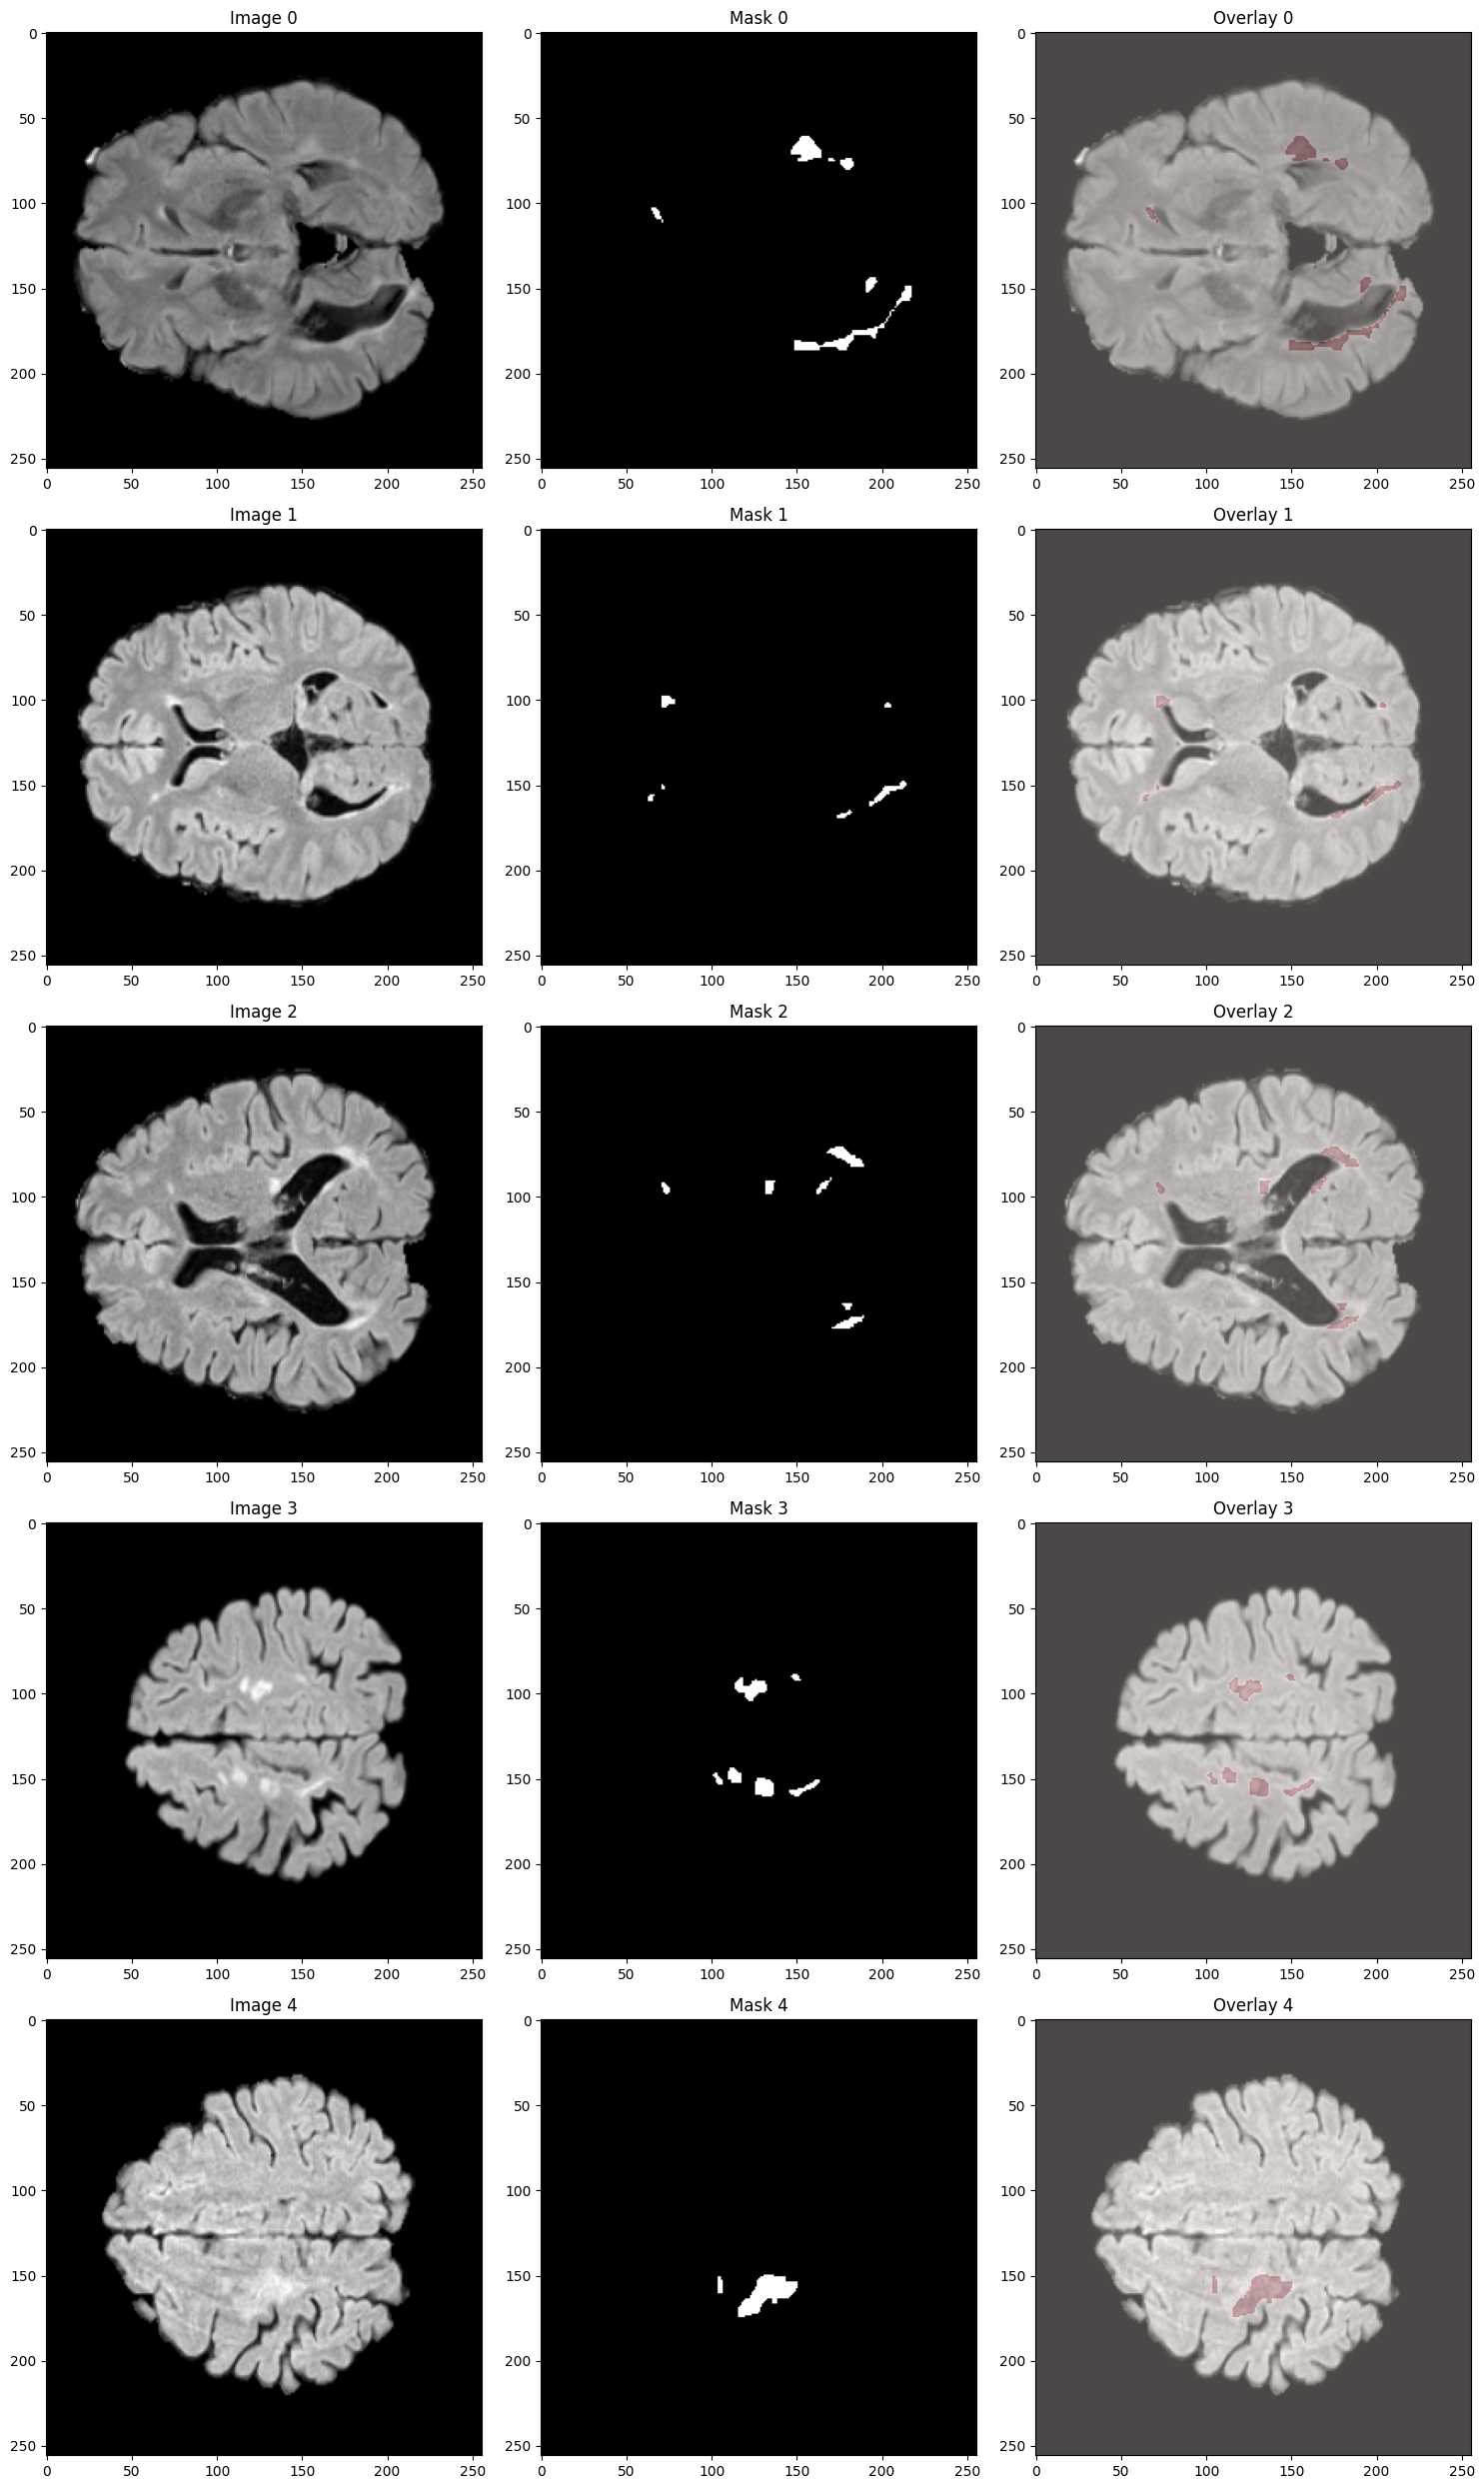

In [ ]:
# Display samples from each split
print("\nDisplaying training samples:")
display_samples(train_ds, num_samples=5)

In [ ]:
# Check mask values in the training dataset
check_mask_values(train_ds)

### Set up the training of the new model

In [ ]:
# Model Compilation
model_preprocessed = create_unet(input_shape=(*train_config.image_size, 1))

# Update optimizer
model_preprocessed.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=train_config.learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07
    ),
    loss=BinaryFocalCrossentropy(apply_class_balancing=True),
    metrics=[dice_coefficient, 'binary_accuracy',
             tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [ ]:
# Setup Callbacks
# Create checkpoint path
checkpoint_path = "checkpoints/model_preprocessed_{epoch:02d}_{val_loss:.2f}.weights.h5" # Changed the file extension

callbacks = [
    ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        save_weights_only=True
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=5,
        min_lr=1e-6
    ),
    TensorBoard(
        log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
        update_freq='epoch'
    ),
    WarmUpCosineDecay(
        warmup_epochs=5,
        total_epochs=train_config.epochs,
        initial_lr=train_config.learning_rate
    )
]

### Train the model and test it

In [ ]:
# Training Loop with updated config access and steps_per_epoch
history = model_preprocessed.fit(
    train_ds,
    validation_data=val_ds,
    epochs=train_config.epochs,
    steps_per_epoch=50,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - binary_accuracy: 0.9721 - dice_coefficient: 0.0120 - loss: 0.2301 - precision_1: 0.0194 - recall_1: 0.0497

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


50/50 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - binary_accuracy: 0.9723 - dice_coefficient: 0.0121 - loss: 0.2290 - precision_1: 0.0194 - recall_1: 0.0491 - val_binary_accuracy: 0.9790 - val_dice_coefficient: 0.0280 - val_loss: 0.0468 - val_precision_1: 0.0239 - val_recall_1: 0.0397 - learning_rate: 2.0000e-04
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 740ms/step - binary_accuracy: 0.9875 - dice_coefficient: 0.0291 - loss: 0.0349 - precision_1: 0.0630 - recall_1: 0.0294 - val_binary_accuracy: 0.9919 - val_dice_coefficient: 0.0237 - val_loss: 0.0439 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 4.0000e-04
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 711ms/step - binary_accuracy: 0.9897 - dice_coefficient: 0.0388 - loss: 0.0215 - precision_1: 0.1477 - recall_1: 0.0473 - val_binary_accuracy: 0.9919 - val_dice_coefficient: 0.0164 - val_loss: 0.0548 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 6.0000e-04
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Evaluate the model on the test dataset
loss, dice, accuracy, recall, precision = model_preprocessed.evaluate(test_ds)

print(f"Test Loss: {loss}")
print(f"Test Dice Coefficient: {dice}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Recall: {recall}")
print(f"Test Precision: {precision}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - binary_accuracy: 0.9974 - dice_coefficient: 0.6645 - loss: 6.9766e-04 - precision_1: 0.9516 - recall_1: 0.7084
Test Loss: 0.0007506737019866705
Test Dice Coefficient: 0.6761460900306702
Test Accuracy: 0.9972232580184937
Test Recall: 0.7113988399505615
Test Precision: 0.9501287341117859


Result of the test :
* Test Loss: **0.00075**
* Test Dice Coefficient: **0.676**
* Test Accuracy: **0.997**
* Test Recall: **0.71**
* Test Precision: **0.95**

Before preprocessing (without Data Augmentation) :
- Test Loss: *0.0133*
- Test Dice Coefficient: *0.643*
- Test Accuracy: *0.996*
- Test Recall: *0.673*
- Test Precision: *0.902*


Preprocessing the data improved the model over all metrics. This is definietly a good technique to use in this problem.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


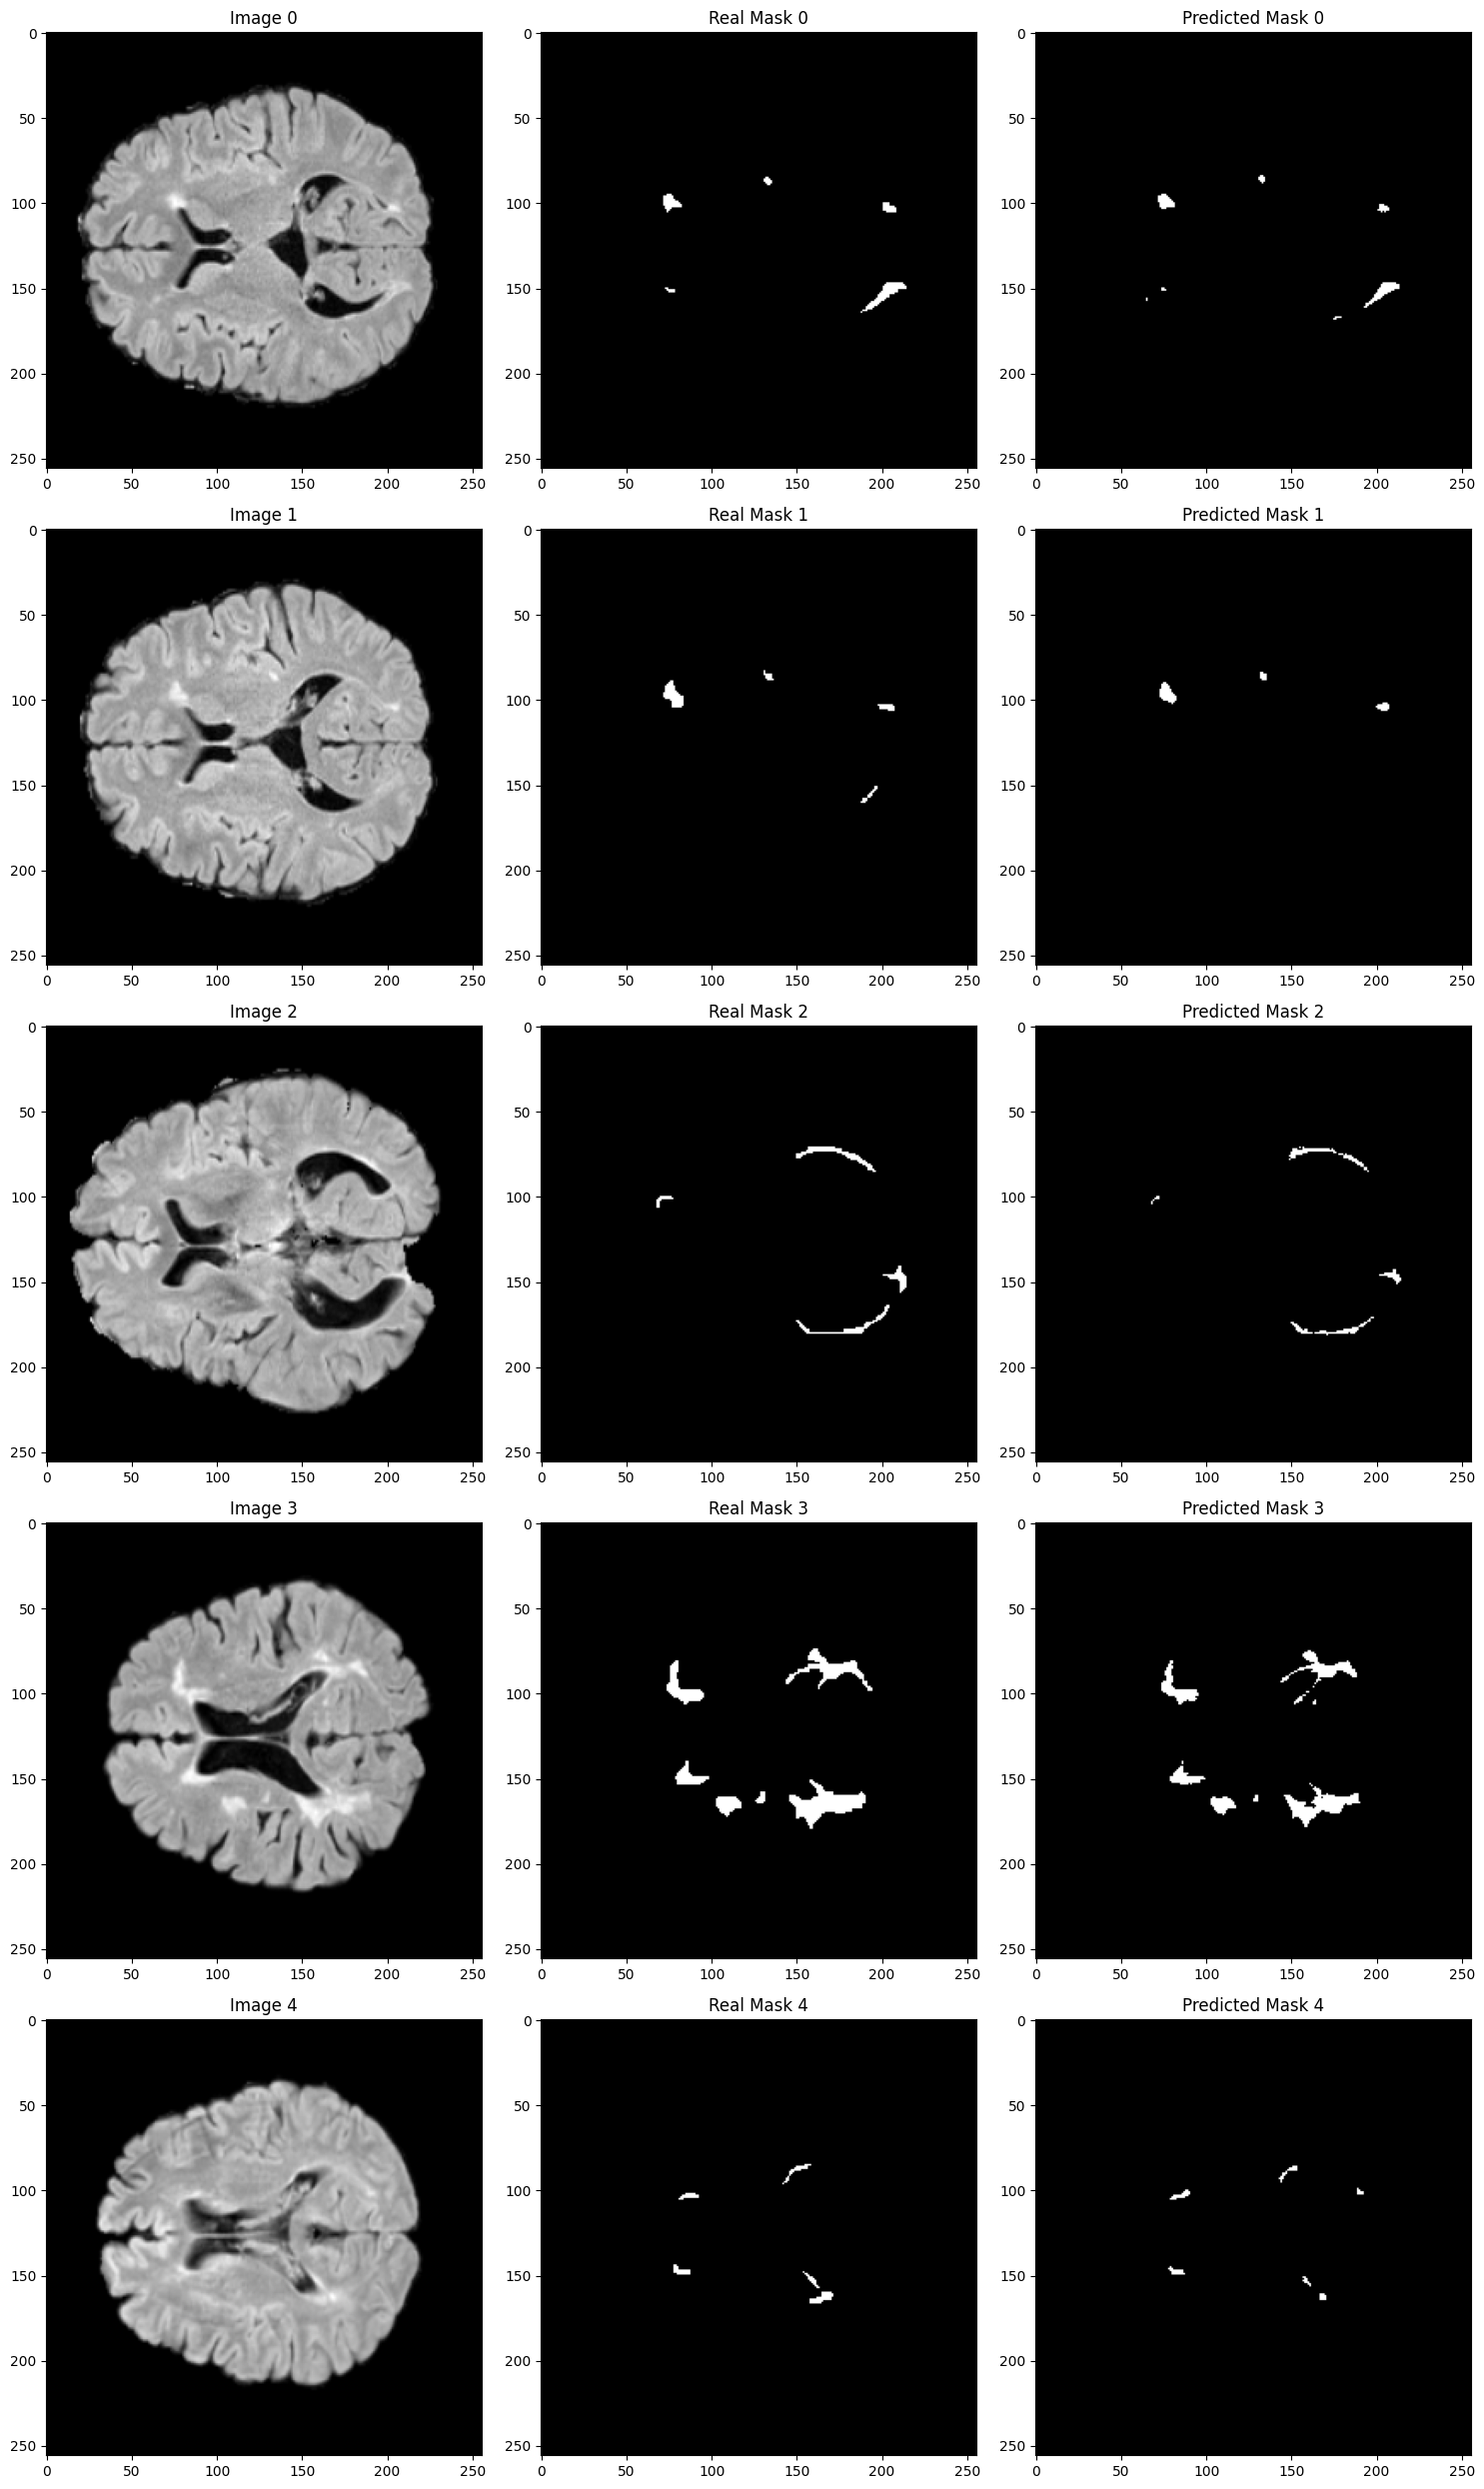

In [ ]:
visualize_predictions(model_preprocessed, test_ds, num_samples=5)

When we look at the predictions, we can see they are way better than the one from the Data Augmentation Model or the Baseline Model.

# Discussion of the Results  

## Improvements  
Before implementing the improvements, I initially believed that Data Augmentation would be the most effective technique due to the limited quantity of data available when focusing on a single MRI type. However, the test results showed that Data Augmentation did not lead to a significant improvement in the metrics. Another approach I explored was extending the training epochs by repeating the dataset. While this showed some promise, its effectiveness was harder to quantify due to its combined use with other techniques.  

The most impactful improvement came from Data Preprocessing, specifically increasing image contrast and applying normalization. This technique proved to yield the best results on this dataset, demonstrating the importance of preprocessing steps in enhancing model performance.  

## Future Work  
Given more time, I would have trained a model that combined both Data Augmentation and Preprocessing. This combination might have mitigated the limitations of Data Augmentation alone and potentially resulted in a model superior to one using Preprocessing alone. Another avenue for future exploration is incorporating different MRI types to create a multimodal model. By using different MRI types as separate input channels for the CNN, the model could leverage diverse information to achieve better overall performance.  